#Tracking# 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
try:
    import seaborn as sns
except ImportError:
    pass
    
# built in python modules
import datetime

# python add-ons
import numpy as np
import pandas as pd

In [2]:
import pvlib
from pvlib.tools import cosd, sind
from pvlib.location import Location

Make some Location objects.

In [3]:
tus = Location(32.2, -111, 'US/Arizona', 700, 'Tucson')
print(tus)
johannesburg = Location(-26.2044, 28.0456, 'Africa/Johannesburg', 1753, 'Johannesburg')
print(johannesburg)

Tucson: latitude=32.2, longitude=-111, tz=US/Arizona, altitude=700
Johannesburg: latitude=-26.2044, longitude=28.0456, tz=Africa/Johannesburg, altitude=1753


Calculate solar position at those locations. To start, we'll choose times near an equinox. Later, we'll test against times near a solstice.

In [4]:
times = pd.date_range(start=datetime.datetime(2014,3,23), end=datetime.datetime(2014,3,24), freq='5Min')

pyephem_tus = pvlib.solarposition.pyephem(times, tus)
pyephem_joh = pvlib.solarposition.pyephem(times, johannesburg)
pyephemout = pyephem_tus # default for notebook

This notebook walks through each step of the ``pvlib.tracking.singleaxis`` function. The steps of the algorithm are:
1. Define input parameters.
2. Transform solar position to South facing coordinate system.
2. Transform solar position to panel coordinate system.
2. Determine the ideal tracking angle when ignoring backtracking.
2. Correct the tracking angle to account for backtracking.
2. Calculate the panel normal vector based on tracking angle.
2. Calculate the solar angle of incidence.
2. Calculate the panel tilt and azimuth.

First, define the input parameters.

In [5]:
apparent_azimuth = pyephemout['apparent_azimuth']
apparent_zenith = pyephemout['apparent_zenith']
axis_tilt = 0
axis_azimuth = 180
latitude = 32
max_angle = 90 
backtrack = True
gcr = 2.0/7.0

times = apparent_azimuth.index

The refernce that this algorithm is based on used an Earth coordinate system where y points south. So, we first transform our solar position vector to this new coordiante system.

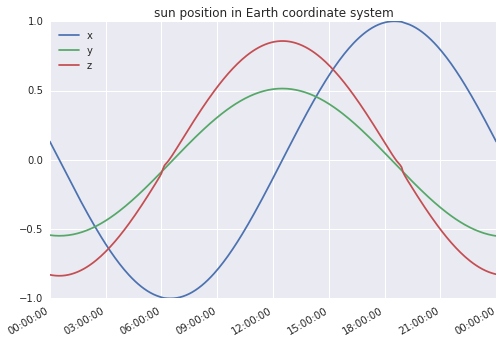

In [6]:
Az = apparent_azimuth - 180
El = 90 - apparent_zenith
x = cosd(El) * sind(Az)
y = cosd(El) * cosd(Az)
z = sind(El)

earth_coords = pd.DataFrame({'x':x,'y':y,'z':z})

earth_coords.plot()
plt.title('sun position in Earth coordinate system')

Transform solar vector to panel coordinate system. For North-South oriented trackers parallel to the ground, the only difference is the sign of the x component. The x components are the same if ``axis_azimuth=180`` and opposite if ``axis_azimuth=0``.

cos(axis_azimuth_south)=1.0, sin(axis_azimuth_south)=0.0
cos(axis_tilt)=1.0, sin(axis_tilt)=0.0


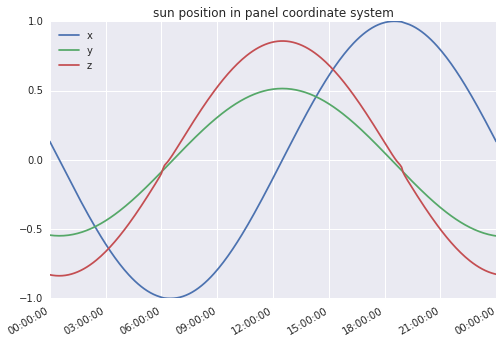

In [7]:
axis_azimuth_south = axis_azimuth - 180

print('cos(axis_azimuth_south)={}, sin(axis_azimuth_south)={}'
      .format(cosd(axis_azimuth_south), sind(axis_azimuth_south)))
print('cos(axis_tilt)={}, sin(axis_tilt)={}'
      .format(cosd(axis_tilt), sind(axis_tilt)))

xp = x*cosd(axis_azimuth_south) - y*sind(axis_azimuth_south);
yp = (x*cosd(axis_tilt)*sind(axis_azimuth_south) +
      y*cosd(axis_tilt)*cosd(axis_azimuth_south) -
      z*sind(axis_tilt))
zp = (x*sind(axis_tilt)*sind(axis_azimuth_south) +
      y*sind(axis_tilt)*cosd(axis_azimuth_south) +
      z*cosd(axis_tilt))

panel_coords = pd.DataFrame({'x':xp,'y':yp,'z':zp})

panel_coords.plot()
plt.title('sun position in panel coordinate system')

 The ideal tracking angle ``wid`` is the rotation to place the sun position 
 vector ``(xp, yp, zp)`` in the ``(y, z)`` plane; i.e. normal to the panel and 
 containing the axis of rotation.  ``wid = 0`` indicates that the panel is 
 horizontal.  Here, our convention is that a clockwise rotation is 
 positive, to view rotation angles in the same frame of reference as 
 azimuth.  For example, for a system with tracking axis oriented south, 
 a rotation toward the east is negative, and a rotation to the west is 
 positive.

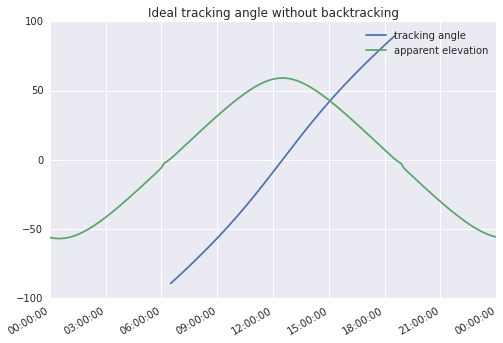

In [8]:
tmp = np.degrees(np.arctan(zp/xp))  # angle from x-y plane to projection of sun vector onto x-z plane

# Obtain wid by translating tmp to convention for rotation angles.
# Have to account for which quadrant of the x-z plane in which the sun 
# vector lies.  Complete solution here but probably not necessary to 
# consider QIII and QIV.
wid = pd.Series(index=times)
wid[(xp>=0) & (zp>=0)] =  90 - tmp[(xp>=0) & (zp>=0)];  # QI
wid[(xp<0)  & (zp>=0)] = -90 - tmp[(xp<0)  & (zp>=0)];  # QII
wid[(xp<0)  & (zp<0)]  = -90 - tmp[(xp<0)  & (zp<0)];   # QIII
wid[(xp>=0) & (zp<0)]  =  90 - tmp[(xp>=0) & (zp<0)];   # QIV

# filter for sun above panel horizon)
u = zp > 0

# apply limits to ideal rotation angle
# set horizontal if zenith<0, sun is below panel horizon
wid[~u] = np.nan

wid.plot(label='tracking angle')
pyephemout['apparent_elevation'].plot(label='apparent elevation')
plt.legend()
plt.title('Ideal tracking angle without backtracking')

Account for backtracking; modified from [1] to account for rotation angle convention being used here.

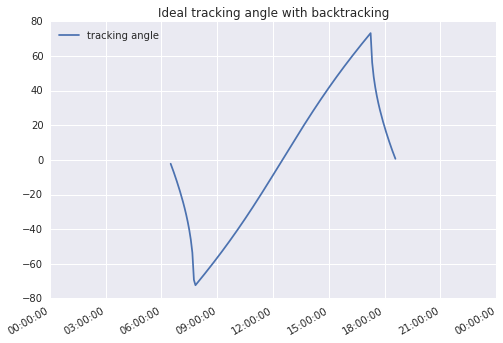

In [9]:
if backtrack:
    axes_distance = 1/gcr
    temp = np.minimum(axes_distance*cosd(wid), 1)

    # backtrack angle
    # (always positive b/c acosd returns values between 0 and 180)
    wc = np.degrees(np.arccos(temp))

    v = wid < 0
    widc = pd.Series(index=times)
    widc[~v] = wid[~v] - wc[~v]; # Eq 4 applied when wid in QI
    widc[v] = wid[v] + wc[v];    # Eq 4 applied when wid in QIV
else:
    widc = wid

widc.plot(label='tracking angle')
#pyephemout['apparent_elevation'].plot(label='apparent elevation')
plt.legend(loc=2)
plt.title('Ideal tracking angle with backtracking')

Compare tracking angle with and without backtracking.

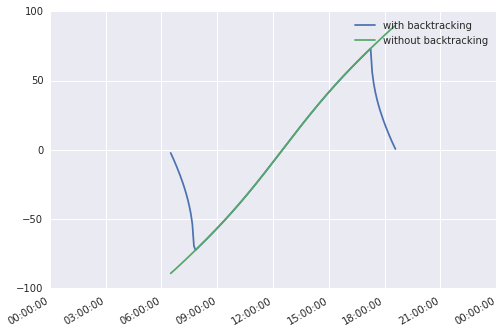

In [10]:
tracking_angles = pd.DataFrame({'with backtracking':widc,'without backtracking':wid})
tracking_angles.plot()
#pyephemout['apparent_elevation'].plot(label='apparent elevation')
plt.legend()

Apply angle restriction.

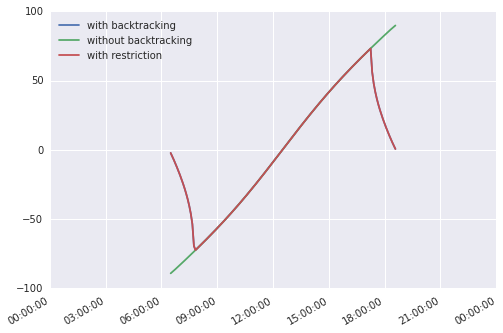

In [11]:
TrkrTheta = widc.copy()
TrkrTheta[TrkrTheta > max_angle] = max_angle
TrkrTheta[TrkrTheta < -max_angle] = -max_angle

tracking_angles['with restriction'] = TrkrTheta
tracking_angles.plot()

Calculate panel normal vector in panel x, y, z coordinates.
y-axis is axis of tracker rotation.  TrkrTheta is a compass angle
(clockwise is positive) rather than a trigonometric angle.

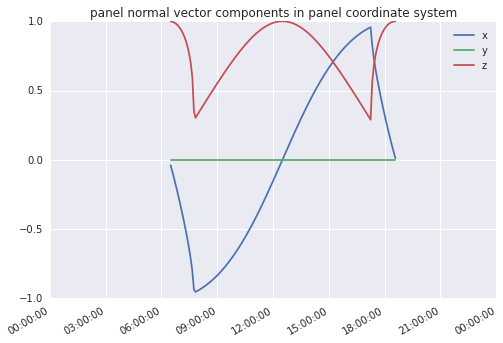

In [12]:
Norm = np.array([sind(TrkrTheta), 
                 TrkrTheta*0,
                 cosd(TrkrTheta)])

norm_df = pd.DataFrame(Norm.T, columns=('x','y','z'), index=times)
norm_df.plot()
plt.title('panel normal vector components in panel coordinate system')
plt.legend()

sun position in vector format in panel-oriented x, y, z coordinates. We've already seen this above, but it's good to look at it again after calculating the tracker normal vector.

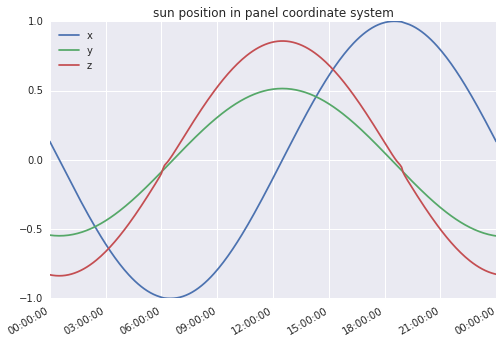

In [13]:
P = np.array([xp, yp, zp])

panel_coords = pd.DataFrame(P.T, columns=('x','y','z'), index=times)

panel_coords.plot()
plt.title('sun position in panel coordinate system')

Calculate angle-of-incidence on panel

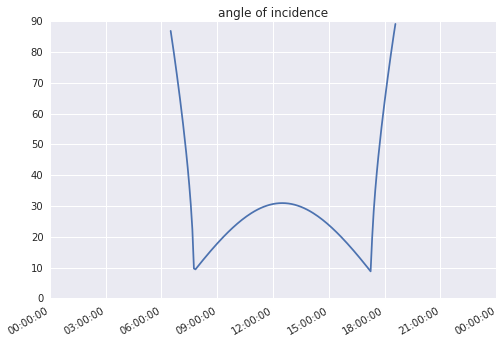

In [14]:
AOI = np.degrees(np.arccos(np.abs(np.sum(P*Norm, axis=0))))
AOI = pd.Series(AOI, index=times)

AOI.plot()
plt.title('angle of incidence')

The power produced by the tracker will be primarily determined by the cosine of the angle of incidence.

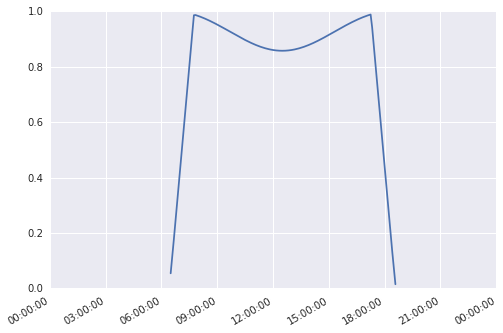

In [15]:
cosd(AOI).plot()

Calculate panel tilt ``surface_tilt`` and azimuth ``surface_azimuth``
in a coordinate system where the panel tilt is the 
angle from horizontal, and the panel azimuth is
the compass angle (clockwise from north) to the projection 
of the panel's normal to the earth's surface. 
These outputs are provided for convenience and comparison 
with other PV software which use these angle conventions.

Project normal vector to earth surface. First rotate about x-axis by angle -axis_tilt so that y-axis is also parallel to earth surface, then project.

cos(axis_azimuth_south)=1.0, sin(axis_azimuth_south)=0.0
cos(axis_tilt)=1.0, sin(axis_tilt)=0.0


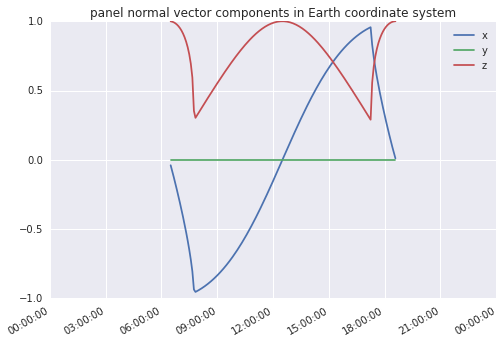

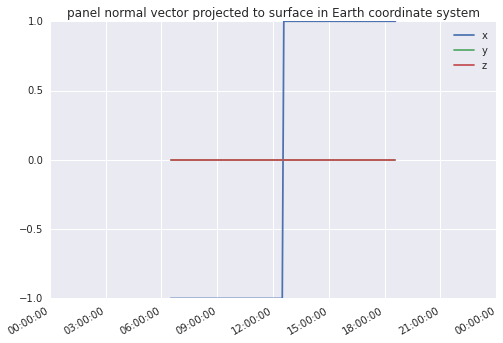

In [16]:
# Calculate standard rotation matrix
print('cos(axis_azimuth_south)={}, sin(axis_azimuth_south)={}'
      .format(cosd(axis_azimuth_south), sind(axis_azimuth_south)))
print('cos(axis_tilt)={}, sin(axis_tilt)={}'
      .format(cosd(axis_tilt), sind(axis_tilt)))

Rot_x = np.array([[1, 0, 0], 
                  [0, cosd(-axis_tilt), -sind(-axis_tilt)], 
                  [0, sind(-axis_tilt), cosd(-axis_tilt)]])

# temp contains the normal vector expressed in earth-surface coordinates
# (z normal to surface, y aligned with tracker axis parallel to earth)
temp = np.dot(Rot_x, Norm).T

# projection to plane tangent to earth surface,
# in earth surface coordinates
projNorm = np.array([temp[:,0], temp[:,1], temp[:,2]*0]).T

# calculate norms
tempnorm = np.sqrt(np.nansum(temp**2, axis=1))
projNormnorm = np.sqrt(np.nansum(projNorm**2, axis=1))
#print('tempnorm={}, projNormnorm={}'.format(tempnorm, projNormnorm))

projNorm = (projNorm.T / projNormnorm).T

temp_df = pd.DataFrame(temp, columns=('x','y','z'), index=times)
temp_df.plot()
plt.title('panel normal vector components in Earth coordinate system')

projNorm_df = pd.DataFrame(projNorm, columns=('x','y','z'), index=times)
projNorm_df.plot()
plt.title('panel normal vector projected to surface in Earth coordinate system')

Calculate surface_azimuth. This takes a few steps. We need to take the arctan, clean up the results, rotate from the panel system to the south-facing Earth system, and finally rotate the Earth system to a north-facing Earth system.

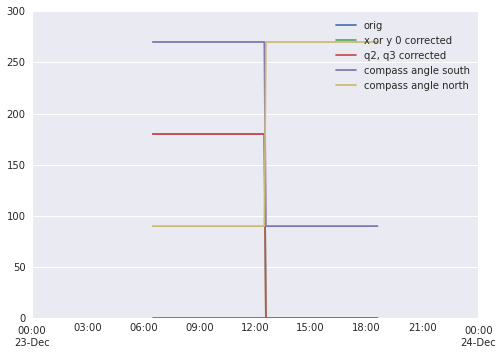

In [53]:
surface_azimuth = pd.Series(np.degrees(np.arctan(projNorm[:,1]/projNorm[:,0])), index=times)
surface_azimuth.plot(label='orig')

# clean up atan when x-coord is zero
surface_azimuth[(projNorm[:,0]==0) & (projNorm[:,1]>0)] =  90
surface_azimuth[(projNorm[:,0]==0) & (projNorm[:,1]<0)] =  -90
# clean up atan when y-coord is zero
surface_azimuth[(projNorm[:,1]==0) & (projNorm[:,0]>0)] =  0
surface_azimuth[(projNorm[:,1]==0) & (projNorm[:,0]<0)] = 180
surface_azimuth.plot(label='x or y 0 corrected')
# correct for QII and QIII
surface_azimuth[(projNorm[:,0]<0) & (projNorm[:,1]>0)] += 180 # QII
surface_azimuth[(projNorm[:,0]<0) & (projNorm[:,1]<0)] += 180 # QIII
surface_azimuth.plot(label='q2, q3 corrected')

surface_azimuth[surface_azimuth<=90] = 90 - surface_azimuth[surface_azimuth<=90]
surface_azimuth[surface_azimuth>90] = 450 - surface_azimuth[surface_azimuth>90]
surface_azimuth.plot(label='compass angle south')

# PVLIB_MATLAB has this latitude correction,
# but I don't think it's latitude dependent if you always
# specify axis_azimuth with respect to North.
if latitude > 0 or True:
    surface_azimuth = surface_azimuth - axis_azimuth
else:
    surface_azimuth = surface_azimuth - axis_azimuth - 180
surface_azimuth[surface_azimuth<0] = 360 + surface_azimuth[surface_azimuth<0]
surface_azimuth.plot(label='compass angle north')

plt.legend()

According to the MATLAB code, surface_azimuth is "The azimuth of the rotated panel, determined by projecting the vector normal to the panel's surface to the earth's surface." This is correct, at least for input azimuth = 180.

Calculate surface_tilt

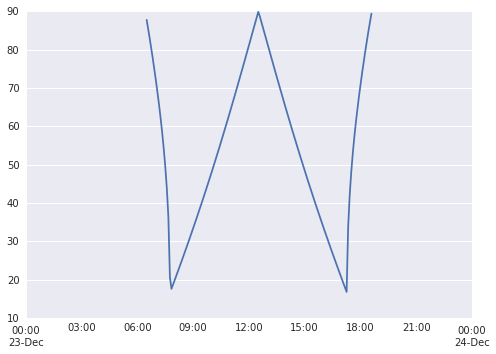

In [54]:
surface_tilt = pd.Series(90 - np.degrees(np.arccos(temp[:,2])), index=times)

surface_tilt.plot()

According to the MATLAB code, surface_tilt is "The angle between the panel surface and the earth surface, accounting for panel rotation." However, the plot above looks like the angle between the normal vector and the earth surface.

In [55]:
reload(pvlib.tracking)

<module 'pvlib.tracking' from '/home/will/git_repos/pvlib-python/pvlib/tracking.py'>

With backtracking

In [56]:
tracker_data = pvlib.tracking.singleaxis(pyephemout['apparent_zenith'], pyephemout['apparent_azimuth'],
                                         latitude=tus.latitude, axis_tilt=0, axis_azimuth=180, max_angle=90,
                                         backtrack=True, gcr=2.0/7.0)

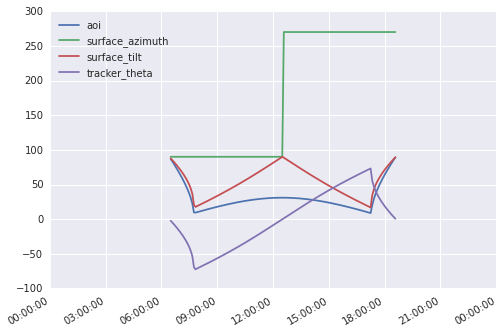

In [57]:
tracker_data.plot()

Without backtracking

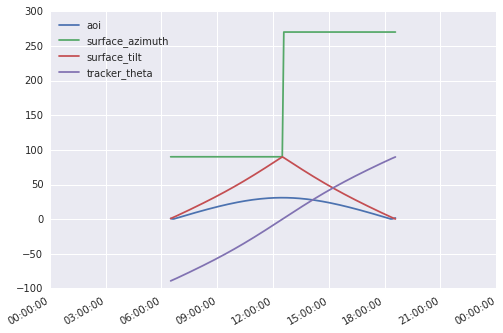

In [58]:
tracker_data = pvlib.tracking.singleaxis(pyephemout['apparent_zenith'], pyephemout['apparent_azimuth'],
                                         latitude=tus.latitude, axis_tilt=0, axis_azimuth=180, max_angle=90,
                                         backtrack=False, gcr=2.0/7.0)
tracker_data.plot()

Explore ground cover ratio

In [59]:
aois = pd.DataFrame(index=pyephemout.index)

for gcr in np.linspace(0, 1, 6):
    tracker_data = pvlib.tracking.singleaxis(pyephemout['apparent_zenith'], pyephemout['apparent_azimuth'],
                                         latitude=tus.latitude, axis_tilt=0, axis_azimuth=180, max_angle=90,
                                         backtrack=True, gcr=gcr)
    aois[gcr] = tracker_data['aoi']

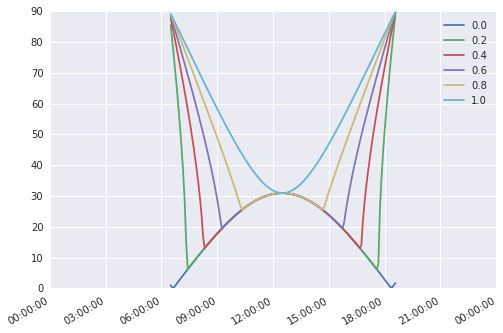

In [60]:
aois.plot()

Ensure that max_angle works.

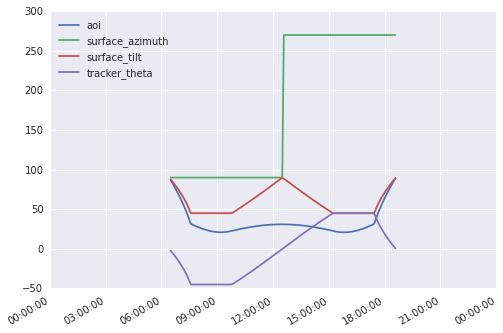

In [61]:
tracker_data = pvlib.tracking.singleaxis(pyephemout['apparent_zenith'], pyephemout['apparent_azimuth'],
                                         latitude=tus.latitude, axis_tilt=0, axis_azimuth=180, max_angle=45,
                                         backtrack=True, gcr=2.0/7.0)
tracker_data.plot()

Play with axis_tilt.

(0, 90)

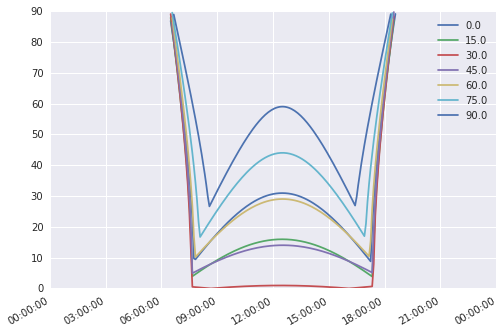

In [62]:
aois = pd.DataFrame(index=pyephemout.index)

for tilt in np.linspace(0, 90, 7):
    tracker_data = pvlib.tracking.singleaxis(pyephemout['apparent_zenith'], pyephemout['apparent_azimuth'],
                                         latitude=tus.latitude, axis_tilt=tilt, axis_azimuth=180, max_angle=90,
                                         backtrack=True, gcr=2/7.)
    aois[tilt] = tracker_data['aoi']
    
aois.plot()
plt.ylim(0,90)

Makes sense if the panels are facing South at solar noon, as expected with ``axis_tilt>0`` and ``axis_azimuth=180``. Next, try to point the panels North.

(0, 100)

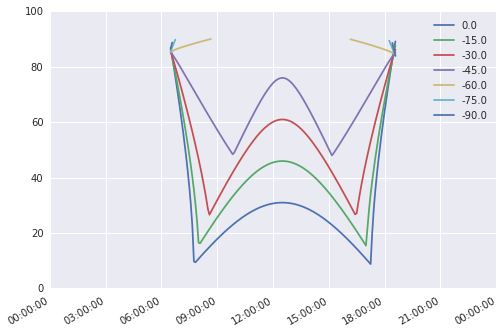

In [63]:
aois = pd.DataFrame(index=pyephemout.index)

for tilt in np.linspace(0, -90, 7):
    tracker_data = pvlib.tracking.singleaxis(pyephemout['apparent_zenith'], pyephemout['apparent_azimuth'],
                                         latitude=tus.latitude, axis_tilt=tilt, axis_azimuth=180, max_angle=90,
                                         backtrack=True, gcr=2/7.)
    aois[tilt] = tracker_data['aoi']
    
aois.plot()
plt.ylim(0,100)

Makes sense if the panels are facing North at solar noon, as expected with ``axis_tilt<0`` and ``axis_azimuth=180``.

Play with axis_azimuth.

(0, 90)

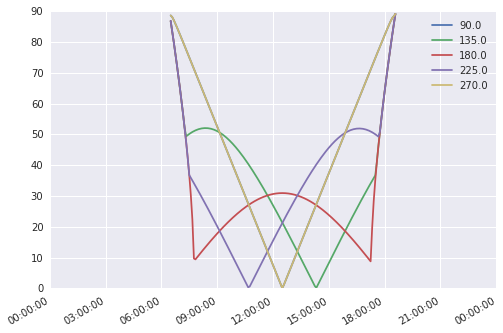

In [64]:
aois = pd.DataFrame(index=pyephemout.index)

for azi in np.linspace(90, 270, 5):
    tracker_data = pvlib.tracking.singleaxis(pyephemout['apparent_zenith'], pyephemout['apparent_azimuth'],
                                         latitude=tus.latitude, axis_tilt=0, axis_azimuth=azi, max_angle=90,
                                         backtrack=True, gcr=2/7.)
    aois[azi] = tracker_data['aoi']
    
aois.plot()
plt.ylim(0,90)

Test the southern hemispere.

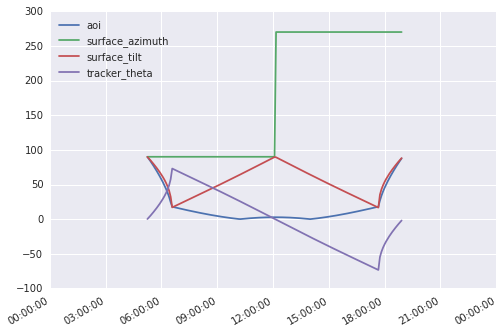

In [65]:
tracker_data = pvlib.tracking.singleaxis(pyephem_joh['apparent_zenith'], pyephem_joh['apparent_azimuth'],
                                         latitude=johannesburg.latitude, axis_tilt=0, axis_azimuth=0, max_angle=90,
                                         backtrack=True, gcr=2.0/7.0)
tracker_data.plot()

Test different seasons.

(-100, 100)

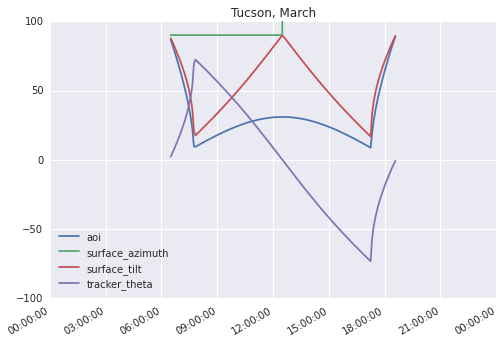

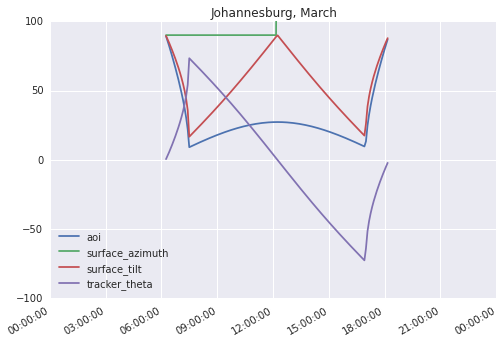

In [66]:
times = pd.date_range(start=datetime.datetime(2014,3,23), end=datetime.datetime(2014,3,24), freq='5Min')

pyephem_tus = pvlib.solarposition.pyephem(times, tus)
pyephem_joh = pvlib.solarposition.pyephem(times, johannesburg)

tracker_data = pvlib.tracking.singleaxis(pyephem_tus['apparent_zenith'], pyephem_tus['apparent_azimuth'],
                                         latitude=tus.latitude, axis_tilt=0, axis_azimuth=0, max_angle=90,
                                         backtrack=True, gcr=2.0/7.0)
tracker_data.plot()
plt.title('Tucson, March')
plt.ylim(-100,100)

tracker_data = pvlib.tracking.singleaxis(pyephem_joh['apparent_zenith'], pyephem_joh['apparent_azimuth'],
                                         latitude=johannesburg.latitude, axis_tilt=0, axis_azimuth=0, max_angle=90,
                                         backtrack=True, gcr=2.0/7.0)
tracker_data.plot()
plt.title('Johannesburg, March')
plt.ylim(-100,100)

(-100, 100)

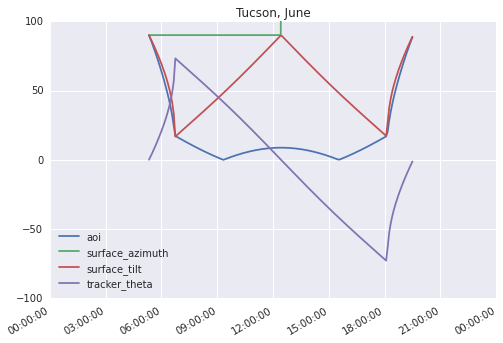

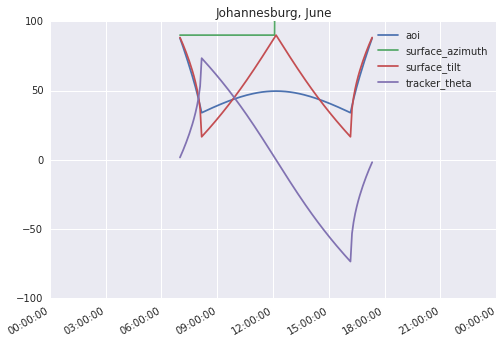

In [67]:
times = pd.date_range(start=datetime.datetime(2014,6,23), end=datetime.datetime(2014,6,24), freq='5Min')

pyephem_tus = pvlib.solarposition.pyephem(times, tus)
pyephem_joh = pvlib.solarposition.pyephem(times, johannesburg)

tracker_data = pvlib.tracking.singleaxis(pyephem_tus['apparent_zenith'], pyephem_tus['apparent_azimuth'],
                                         latitude=tus.latitude, axis_tilt=0, axis_azimuth=0, max_angle=90,
                                         backtrack=True, gcr=2.0/7.0)
tracker_data.plot()
plt.title('Tucson, June')
plt.ylim(-100,100)

tracker_data = pvlib.tracking.singleaxis(pyephem_joh['apparent_zenith'], pyephem_joh['apparent_azimuth'],
                                         latitude=johannesburg.latitude, axis_tilt=0, axis_azimuth=0, max_angle=90,
                                         backtrack=True, gcr=2.0/7.0)
tracker_data.plot()
plt.title('Johannesburg, June')
plt.ylim(-100,100)

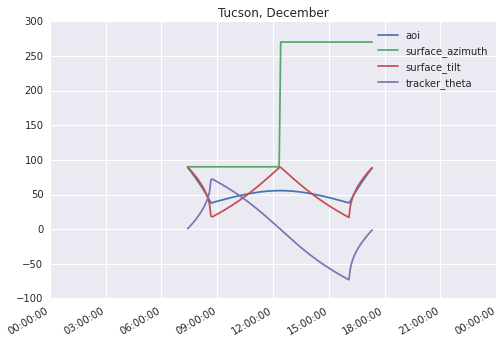

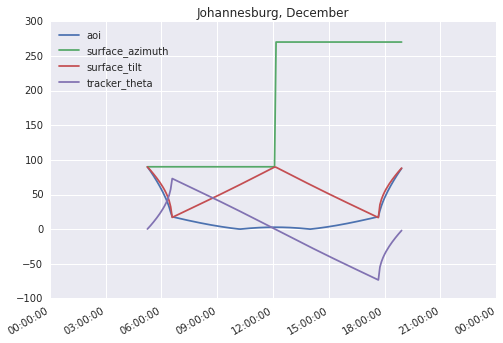

In [68]:
times = pd.date_range(start=datetime.datetime(2014,12,23), end=datetime.datetime(2014,12,24), freq='5Min')

pyephem_tus = pvlib.solarposition.pyephem(times, tus)
pyephem_joh = pvlib.solarposition.pyephem(times, johannesburg)

tracker_data = pvlib.tracking.singleaxis(pyephem_tus['apparent_zenith'], pyephem_tus['apparent_azimuth'],
                                         latitude=tus.latitude, axis_tilt=0, axis_azimuth=0, max_angle=90,
                                         backtrack=True, gcr=2.0/7.0)
tracker_data.plot()
plt.title('Tucson, December')

tracker_data = pvlib.tracking.singleaxis(pyephem_joh['apparent_zenith'], pyephem_joh['apparent_azimuth'],
                                         latitude=johannesburg.latitude, axis_tilt=0, axis_azimuth=0, max_angle=90,
                                         backtrack=True, gcr=2.0/7.0)
tracker_data.plot()
plt.title('Johannesburg, December')

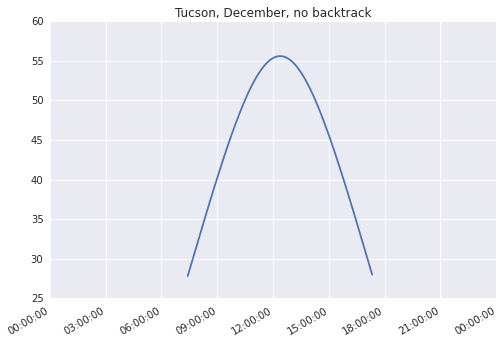

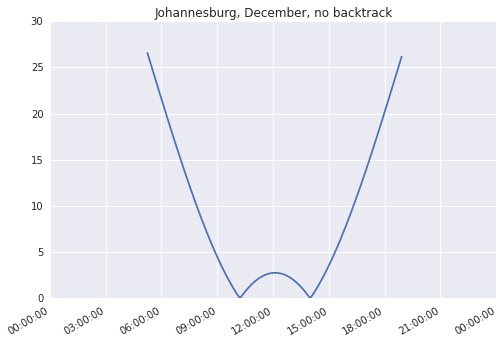

In [69]:
times = pd.date_range(start=datetime.datetime(2014,12,23), end=datetime.datetime(2014,12,24), freq='5Min')

pyephem_tus = pvlib.solarposition.pyephem(times, tus)
pyephem_joh = pvlib.solarposition.pyephem(times, johannesburg)

tracker_data = pvlib.tracking.singleaxis(pyephem_tus['apparent_zenith'], pyephem_tus['apparent_azimuth'],
                                         latitude=tus.latitude, axis_tilt=0, axis_azimuth=0, max_angle=90,
                                         backtrack=False, gcr=2.0/7.0)
tracker_data['aoi'].plot()
plt.title('Tucson, December, no backtrack')

tracker_data = pvlib.tracking.singleaxis(pyephem_joh['apparent_zenith'], pyephem_joh['apparent_azimuth'],
                                         latitude=johannesburg.latitude, axis_tilt=0, axis_azimuth=0, max_angle=90,
                                         backtrack=False, gcr=2.0/7.0)
plt.figure()
tracker_data['aoi'].plot()
plt.title('Johannesburg, December, no backtrack')

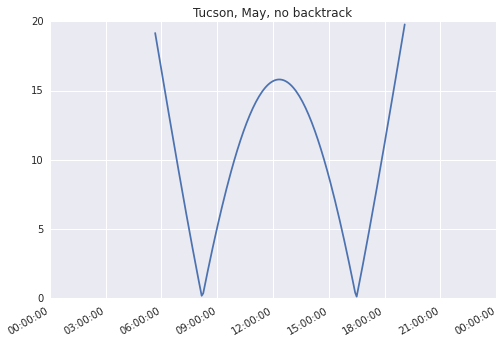

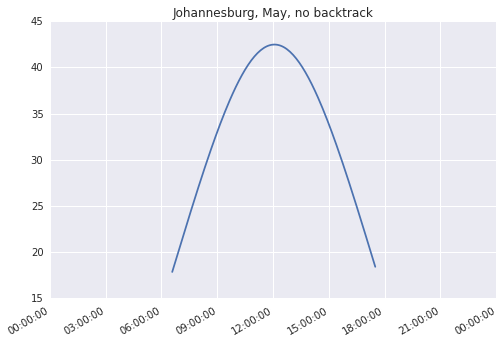

In [70]:
times = pd.date_range(start=datetime.datetime(2014,5,5), end=datetime.datetime(2014,5,6), freq='5Min')

pyephem_tus = pvlib.solarposition.pyephem(times, tus)
pyephem_joh = pvlib.solarposition.pyephem(times, johannesburg)

tracker_data = pvlib.tracking.singleaxis(pyephem_tus['apparent_zenith'], pyephem_tus['apparent_azimuth'],
                                         latitude=tus.latitude, axis_tilt=0, axis_azimuth=0, max_angle=90,
                                         backtrack=False, gcr=2.0/7.0)
tracker_data['aoi'].plot()
plt.title('Tucson, May, no backtrack')

tracker_data = pvlib.tracking.singleaxis(pyephem_joh['apparent_zenith'], pyephem_joh['apparent_azimuth'],
                                         latitude=johannesburg.latitude, axis_tilt=0, axis_azimuth=0, max_angle=90,
                                         backtrack=False, gcr=2.0/7.0)
plt.figure()
tracker_data['aoi'].plot()
plt.title('Johannesburg, May, no backtrack')

Finally, we'll put the tracker data together with the irradiance algorithms to determine plane-of-array irradiance.

(-100, 100)

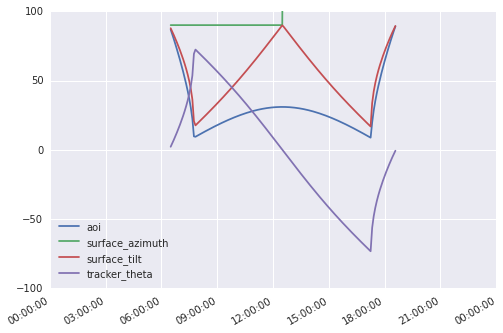

In [71]:
times = pd.date_range(start=datetime.datetime(2014,3,23), end=datetime.datetime(2014,3,24), freq='5Min')

pyephem_tus = pvlib.solarposition.pyephem(times, tus)
pyephem_joh = pvlib.solarposition.pyephem(times, johannesburg)

tracker_data = pvlib.tracking.singleaxis(pyephem_tus['apparent_zenith'], pyephem_tus['apparent_azimuth'],
                                         latitude=tus.latitude, axis_tilt=0, axis_azimuth=0, max_angle=90,
                                         backtrack=True, gcr=2.0/7.0)
tracker_data.plot()
plt.ylim(-100,100)

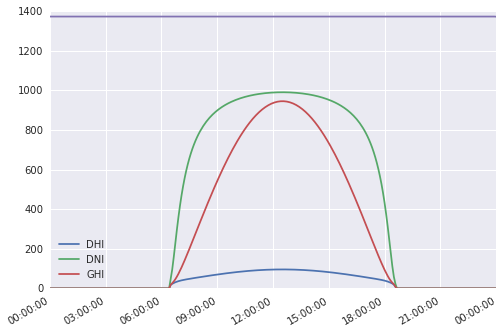

In [72]:
irrad_data = pvlib.clearsky.ineichen(times, tus, solarposition_method='pyephem')
dni_et = pd.Series(pvlib.irradiance.extraradiation(times.dayofyear, method='asce'), index=times).tz_localize(tus.tz)
irrad_data.plot()
dni_et.plot(label='DNI ET')

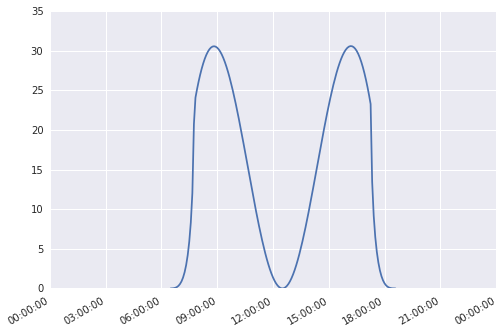

In [73]:
ground_irrad = pvlib.irradiance.grounddiffuse(90-tracker_data['surface_tilt'], irrad_data['GHI'], albedo=.25)
ground_irrad.plot()

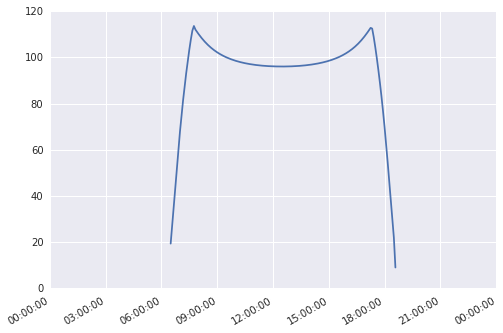

In [74]:
ephem_data = pyephem_tus

haydavies_diffuse = pvlib.irradiance.haydavies(90-tracker_data['surface_tilt'], tracker_data['surface_azimuth'], 
                                                irrad_data['DHI'], irrad_data['DNI'], dni_et,
                                                ephem_data['apparent_zenith'], ephem_data['apparent_azimuth'])
haydavies_diffuse.plot(label='haydavies diffuse')

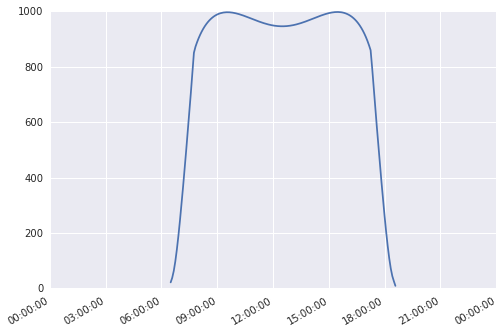

In [75]:
global_in_plane = cosd(tracker_data['aoi'])*irrad_data['DNI'] + haydavies_diffuse + ground_irrad
global_in_plane.plot()

Do it again for another time of year.

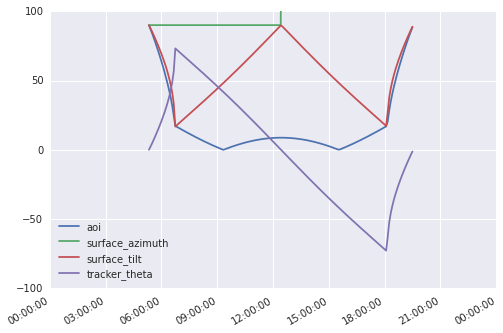

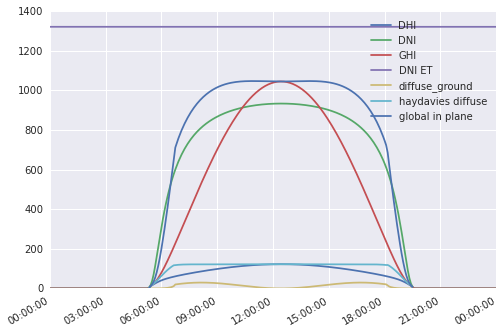

In [76]:
times = pd.date_range(start=datetime.datetime(2014,6,23), end=datetime.datetime(2014,6,24), freq='5Min')

pyephem_tus = pvlib.solarposition.pyephem(times, tus)
pyephem_joh = pvlib.solarposition.pyephem(times, johannesburg)

tracker_data = pvlib.tracking.singleaxis(pyephem_tus['apparent_zenith'], pyephem_tus['apparent_azimuth'],
                                         latitude=tus.latitude, axis_tilt=0, axis_azimuth=0, max_angle=90,
                                         backtrack=True, gcr=2.0/7.0)
tracker_data.plot()
plt.ylim(-100,100)

irrad_data = pvlib.clearsky.ineichen(times, tus, solarposition_method='pyephem')
dni_et = pd.Series(pvlib.irradiance.extraradiation(times.dayofyear, method='asce'), index=times).tz_localize(tus.tz)
plt.figure()
irrad_data.plot()
dni_et.plot(label='DNI ET')

ground_irrad = pvlib.irradiance.grounddiffuse(90-tracker_data['surface_tilt'], irrad_data['GHI'], albedo=.25)
ground_irrad.plot()

ephem_data = pyephem_tus

haydavies_diffuse = pvlib.irradiance.haydavies(90-tracker_data['surface_tilt'], tracker_data['surface_azimuth'], 
                                                irrad_data['DHI'], irrad_data['DNI'], dni_et,
                                                ephem_data['apparent_zenith'], ephem_data['apparent_azimuth'])
haydavies_diffuse.plot(label='haydavies diffuse')

global_in_plane = cosd(tracker_data['aoi'])*irrad_data['DNI'] + haydavies_diffuse + ground_irrad
global_in_plane.plot(label='global in plane')

plt.legend()

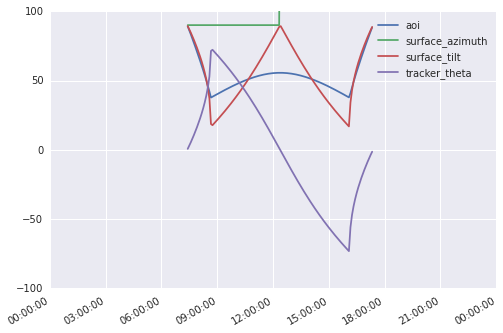

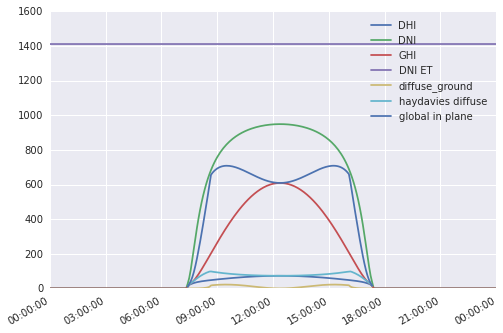

In [77]:
times = pd.date_range(start=datetime.datetime(2014,12,23), end=datetime.datetime(2014,12,24), freq='5Min')

pyephem_tus = pvlib.solarposition.pyephem(times, tus)
pyephem_joh = pvlib.solarposition.pyephem(times, johannesburg)

tracker_data = pvlib.tracking.singleaxis(pyephem_tus['apparent_zenith'], pyephem_tus['apparent_azimuth'],
                                         latitude=tus.latitude, axis_tilt=0, axis_azimuth=0, max_angle=90,
                                         backtrack=True, gcr=2.0/7.0)
tracker_data.plot()
plt.ylim(-100,100)

irrad_data = pvlib.clearsky.ineichen(times, tus, solarposition_method='pyephem')
dni_et = pd.Series(pvlib.irradiance.extraradiation(times.dayofyear, method='asce'), index=times).tz_localize(tus.tz)
plt.figure()
irrad_data.plot()
dni_et.plot(label='DNI ET')

ground_irrad = pvlib.irradiance.grounddiffuse(90-tracker_data['surface_tilt'], irrad_data['GHI'], albedo=.25)
ground_irrad.plot()

ephem_data = pyephem_tus

haydavies_diffuse = pvlib.irradiance.haydavies(90-tracker_data['surface_tilt'], tracker_data['surface_azimuth'], 
                                                irrad_data['DHI'], irrad_data['DNI'], dni_et,
                                                ephem_data['apparent_zenith'], ephem_data['apparent_azimuth'])
haydavies_diffuse.plot(label='haydavies diffuse')

global_in_plane = cosd(tracker_data['aoi'])*irrad_data['DNI'] + haydavies_diffuse + ground_irrad
global_in_plane.plot(label='global in plane')

plt.legend()

sketch of automated tests

test solar noon

In [78]:
apparent_zenith = pd.Series([10])
apparent_azimuth = pd.Series([180])
tracker_data = pvlib.tracking.singleaxis(apparent_zenith, apparent_azimuth,
                                         axis_tilt=0, axis_azimuth=0, max_angle=90,
                                         backtrack=True, gcr=2.0/7.0)
tracker_data

,aoi,surface_azimuth,surface_tilt,tracker_theta
0,10,NaN,90,0


In [79]:
apparent_zenith = pd.Series([60])
apparent_azimuth = pd.Series([90])
tracker_data = pvlib.tracking.singleaxis(apparent_zenith, apparent_azimuth,
                                         axis_tilt=0, axis_azimuth=180, max_angle=90,
                                         backtrack=True, gcr=2.0/7.0)
tracker_data

,aoi,surface_azimuth,surface_tilt,tracker_theta
0,0,90,30,-60


In [80]:
apparent_zenith = pd.Series([60])
apparent_azimuth = pd.Series([90])
tracker_data = pvlib.tracking.singleaxis(apparent_zenith, apparent_azimuth,
                                         axis_tilt=0, axis_azimuth=0, max_angle=90,
                                         backtrack=True, gcr=2.0/7.0)
tracker_data

,aoi,surface_azimuth,surface_tilt,tracker_theta
0,0,90,30,60


Test max

In [81]:
apparent_zenith = pd.Series([60])
apparent_azimuth = pd.Series([90])
tracker_data = pvlib.tracking.singleaxis(apparent_zenith, apparent_azimuth,
                                         axis_tilt=0, axis_azimuth=0, max_angle=45,
                                         backtrack=True, gcr=2.0/7.0)
tracker_data

,aoi,surface_azimuth,surface_tilt,tracker_theta
0,15,90,45,45


Test backtrack bool

In [82]:
apparent_zenith = pd.Series([80])
apparent_azimuth = pd.Series([90])
tracker_data = pvlib.tracking.singleaxis(apparent_zenith, apparent_azimuth,
                                         axis_tilt=0, axis_azimuth=0, max_angle=90,
                                         backtrack=True, gcr=2.0/7.0)
tracker_data

,aoi,surface_azimuth,surface_tilt,tracker_theta
0,52.571666,90,62.571666,27.428334


In [83]:
apparent_zenith = pd.Series([80])
apparent_azimuth = pd.Series([90])
tracker_data = pvlib.tracking.singleaxis(apparent_zenith, apparent_azimuth,
                                         axis_tilt=0, axis_azimuth=0, max_angle=90,
                                         backtrack=False, gcr=2.0/7.0)
tracker_data

,aoi,surface_azimuth,surface_tilt,tracker_theta
0,0.000001,90,10,80


Test axis_tilt

In [84]:
apparent_zenith = pd.Series([30])
apparent_azimuth = pd.Series([135])
tracker_data = pvlib.tracking.singleaxis(apparent_zenith, apparent_azimuth,
                                         axis_tilt=30, axis_azimuth=180, max_angle=90,
                                         backtrack=True, gcr=2.0/7.0)
tracker_data

,aoi,surface_azimuth,surface_tilt,tracker_theta
0,7.286245,142.6573,54.012585,-20.88121


In [85]:
apparent_zenith = pd.Series([30])
apparent_azimuth = pd.Series([135])
tracker_data = pvlib.tracking.singleaxis(apparent_zenith, apparent_azimuth,
                                         axis_tilt=30, axis_azimuth=0, max_angle=90,
                                         backtrack=True, gcr=2.0/7.0)
tracker_data

,aoi,surface_azimuth,surface_tilt,tracker_theta
0,47.66322,50.969695,47.484781,31.665508


Test axis_azimuth

In [86]:
apparent_zenith = pd.Series([30])
apparent_azimuth = pd.Series([90])
tracker_data = pvlib.tracking.singleaxis(apparent_zenith, apparent_azimuth,
                                         axis_tilt=0, axis_azimuth=90, max_angle=90,
                                         backtrack=True, gcr=2.0/7.0)
tracker_data

,aoi,surface_azimuth,surface_tilt,tracker_theta
0,30,NaN,90,0


In [87]:
apparent_zenith = pd.Series([30])
apparent_azimuth = pd.Series([180])
tracker_data = pvlib.tracking.singleaxis(apparent_zenith, apparent_azimuth,
                                         axis_tilt=0, axis_azimuth=90, max_angle=90,
                                         backtrack=True, gcr=2.0/7.0)
tracker_data

,aoi,surface_azimuth,surface_tilt,tracker_theta
0,0,0,60,30
